# 1. Install and Import Dependencies

In [1]:
!cd yolov5 & pip install -r requirements.txt

  Obtaining dependency information for gitpython>=3.1.30 from https://files.pythonhosted.org/packages/67/50/742c2fb60989b76ccf7302c7b1d9e26505d7054c24f08cc7ec187faaaea7/GitPython-3.1.32-py3-none-any.whl.metadata
  Obtaining dependency information for matplotlib>=3.3 from https://files.pythonhosted.org/packages/b2/b6/c6596fbc30899e6da31450053054d7da61a21a3f510544fb7cb7658a3de3/matplotlib-3.7.2-cp38-cp38-macosx_10_12_x86_64.whl.metadata
  Obtaining dependency information for numpy>=1.22.2 from https://files.pythonhosted.org/packages/11/10/943cfb579f1a02909ff96464c69893b1d25be3731b5d3652c2e0cf1281ea/numpy-1.24.4-cp38-cp38-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for opencv-python>=4.1.1 from https://files.pythonhosted.org/packages/8a/6f/8aa049b66bcba8b5a4dc872ecfdbcd8603a96704b070fde22222e479c3d7/opencv_python-4.8.0.76-cp37-abi3-macosx_10_16_x86_64.whl.metadata
  Obtaining dependency information for Pillow>=7.1.2 from https://files.pythonhosted.org/packages/5a/29

  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached GitPython-3.1.32-py3-none-any.whl (188 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 8.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 13.5 MB/s eta 0:00:0000:0100:01
Using cached opencv_python-4.8.0.76-cp37-abi3-macosx_10_16_x86_64.whl (54.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.7 MB/s eta 0:00:0000:0100:01
Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.0/613.0 kB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 5.4 MB/s eta 0:00:00ta 0:00:01
   ━━

In [2]:
import os 
from scipy.spatial import distance as dist
from threading import Thread
import numpy as np
import pandas as pd
import time
import cv2
import random
import shutil
from PIL import Image
import torch
from matplotlib import pyplot as plt

# Creating more data

In [8]:
#creating 25 images for awake and drwosy
labels = ['Awake', 'Drowsy']  #yawing 
number_imgs = 50
# collect iamge from video 
cap = cv2.VideoCapture(0) #camera index 0
# Loop through labels
for label in labels:
    IMAGES_PATH = os.path.join('synthetic_data', label)
    print('Collecting images for {}'.format(label))
    time.sleep(5)
    
    # Loop through image range
    for img_num in range(number_imgs):
        print('Collecting images for {}, image number {}'.format(label, img_num))
        
        # Webcam feed
        ret, frame = cap.read()
        
        # Naming out image path
        imgname = os.path.join(IMAGES_PATH,str(img_num)+'.jpg')
        
        # Writes out image to file 
        cv2.imwrite(imgname, frame)
        
        # Render to the screen
        cv2.imshow('Image Collection', frame)
        
        # 2 second delay between captures
        time.sleep(2)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

# Labelling images into Awake, Yawn and Drowsy and Creating annotation for pre-divided data

In [3]:
# Path to the directory containing your labeled data
data_dir = 'datapreprocessing/Dataset/'
annotation_labels_dir = 'datapreprocessing/Labels/'
annotation_images_dir = 'datapreprocessing/Annotation_images/'
multiple_dir= 'datapreprocessing/multiple/'
# Load the pre-trained face detection model from OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Define the class index for faces (can be 0)
class_index = 0

# Iterate through each subfolder
for label in os.listdir(data_dir):
    '''------------------------------------------------------
        Labelling the image according to the folder they are in
    ------------------------------------------------------'''
    if label=="Awake":
        class_index = 0
    elif label=="Drowsy":
        class_index = 1
    else: #yawn
        class_index = 2
        
    total_image, no_face, multiple_face = 0, 0, 0
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        annotation_label_dir = os.path.join(annotation_labels_dir, label)
        os.makedirs(annotation_label_dir, exist_ok=True)
        annotation_image_dir = os.path.join(annotation_images_dir, label)
        os.makedirs(annotation_image_dir, exist_ok=True)

        for image_file in os.listdir(label_dir):
            if image_file.lower().endswith('.jpg'):
                total_image+=1
                image_path = os.path.join(label_dir, image_file)

                '''------------------------------------------------------
                annotating the data and image and saving them using cv2
                ------------------------------------------------------'''

                image = cv2.imread(image_path)
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.3, minNeighbors=6, minSize=(300, 300))

                if len(faces) == 1:  # Limit to one face detection per image
                    x, y, w, h = faces[0]

                    annotation_path = os.path.join(annotation_label_dir, f'{label}_{os.path.splitext(image_file)[0]}.txt')
                    with open(annotation_path, 'w') as annotation_file:
                        img_height, img_width, _ = image.shape
                        x_center = (x + w / 2) / img_width
                        y_center = (y + h / 2) / img_height
                        width = w / img_width
                        height = h / img_height
                        annotation_file.write(f'{class_index} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n')

                    # Save annotated image
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    new_image_name = f'{label}_{image_file}'
                    new_image_path = os.path.join(annotation_image_dir, new_image_name)
                    cv2.imwrite(new_image_path, image)
                
                elif len(faces) == 0:
                    no_face+=1
                else:
                    multiple_face+=1
                    x, y, w, h = faces[0]
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    new_image_name = f'{label}_{image_file}'
                    new_image_path = os.path.join(multiple_dir, new_image_name)
                    cv2.imwrite(new_image_path, image)

                '''------------------------------------------------------
                renaming images with label name and deleteing rest of the image 
                ------------------------------------------------------'''
                if len(faces)==1:
                    new_image_name = f'{label}_{image_file}'
                    new_image_path = os.path.join(label_dir, new_image_name)
                    os.rename(image_path, new_image_path)
                else: 
                    os.remove(image_path)
                    
        print(label,"total_image", total_image, (total_image-no_face-multiple_face)/total_image, "no_face", 
                  no_face,no_face/total_image, "\nmultiple_face", multiple_face,multiple_face/total_image )
            

Drowsy total_image 633 0.9747235387045814 no_face 16 0.02527646129541864 
multiple_face 0 0.0
Yawn total_image 169 1.0 no_face 0 0.0 
multiple_face 0 0.0
Awake total_image 399 0.9949874686716792 no_face 2 0.005012531328320802 
multiple_face 0 0.0


# dividng data to train and validate for training of model

In [5]:
# Set the path to the directory containing your labeled data and annotations
data_dir = 'datapreprocessing/Dataset/'
annotation_labels_dir = 'datapreprocessing/Labels/'

train_dir = 'preprocessed_data/train/'
validate_dir = 'preprocessed_data/validate/'

train_ratio = 0.7
validate_ratio = 0.3

# Iterate through each subfolder (label)
for label in os.listdir(data_dir):
    image_dir = os.path.join(data_dir, label)
    annotation_label_dir = os.path.join(annotation_labels_dir, label)
    if os.path.isdir(image_dir) and os.path.isdir(annotation_label_dir):

        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
     
        total_images = len(image_files)
        
        random.shuffle(image_files)
        
        train_split = int(total_images * train_ratio)
        validate_split = total_images - train_split
        
        train_images = image_files[:train_split]
        validate_images = image_files[train_split:]
        
        for split, split_dir in [(train_images, train_dir), (validate_images, validate_dir)]:

            new_image_dir = os.path.join(split_dir, 'images')
            new_label_dir = os.path.join(split_dir, 'labels')

            os.makedirs(new_image_dir, exist_ok=True)
            os.makedirs(new_label_dir, exist_ok=True)
                
            for image_file in split:
                print("image_file:", image_file)
                # Move images to the split directory
                image_source_path = os.path.join(image_dir, image_file)
                image_destination_path = os.path.join(new_image_dir, image_file)
                shutil.copy2(image_source_path, image_destination_path)
                print(f'Copied image : {image_file}')
                
                #copy annotation
                label_source_path = os.path.join(annotation_label_dir, f'{os.path.splitext(image_file)[0]}.txt')
                label_destination_path = os.path.join(new_label_dir, f'{os.path.splitext(image_file)[0]}.txt')
                
                print("label_source_path:", label_source_path, label_destination_path)
                shutil.copy2(label_source_path, label_destination_path)
                print(f'Copied label : {image_file}')
                
#         label_source_path = os.path.join(annotation_label_dir, f'{os.path.splitext(image_file)[0]}.txt')
#         label_destination_path = os.path.join(new_label_subdir, f'{os.path.splitext(image_file)[0]}.txt')
        
#         shutil.copy2(label_source_path, label_destination_path)
#         print(f'Copied label : {os.path.splitext(image_file)[0]}.txt')


image_file: Drowsy_3507.jpg
Copied image : Drowsy_3507.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_3507.txt preprocessed_data/train/labels/Drowsy_3507.txt
Copied label : Drowsy_3507.jpg
image_file: Drowsy_1088.jpg
Copied image : Drowsy_1088.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1088.txt preprocessed_data/train/labels/Drowsy_1088.txt
Copied label : Drowsy_1088.jpg
image_file: Drowsy_359.jpg
Copied image : Drowsy_359.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_359.txt preprocessed_data/train/labels/Drowsy_359.txt
Copied label : Drowsy_359.jpg
image_file: Drowsy_1591.jpg
Copied image : Drowsy_1591.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1591.txt preprocessed_data/train/labels/Drowsy_1591.txt
Copied label : Drowsy_1591.jpg
image_file: Drowsy_319.jpg
Copied image : Drowsy_319.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_319.txt preprocessed_data/train/labels/Drowsy_319.txt
Copied label : Drows

Copied image : Drowsy_330.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_330.txt preprocessed_data/train/labels/Drowsy_330.txt
Copied label : Drowsy_330.jpg
image_file: Drowsy_2932.jpg
Copied image : Drowsy_2932.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_2932.txt preprocessed_data/train/labels/Drowsy_2932.txt
Copied label : Drowsy_2932.jpg
image_file: Drowsy_1786.jpg
Copied image : Drowsy_1786.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1786.txt preprocessed_data/train/labels/Drowsy_1786.txt
Copied label : Drowsy_1786.jpg
image_file: Drowsy_3445.jpg
Copied image : Drowsy_3445.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_3445.txt preprocessed_data/train/labels/Drowsy_3445.txt
Copied label : Drowsy_3445.jpg
image_file: Drowsy_1690.jpg
Copied image : Drowsy_1690.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1690.txt preprocessed_data/train/labels/Drowsy_1690.txt
Copied label : Drowsy_1690.jpg
image_file: 

Copied image : Drowsy_1080.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1080.txt preprocessed_data/train/labels/Drowsy_1080.txt
Copied label : Drowsy_1080.jpg
image_file: Drowsy_1639.jpg
Copied image : Drowsy_1639.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1639.txt preprocessed_data/train/labels/Drowsy_1639.txt
Copied label : Drowsy_1639.jpg
image_file: Drowsy_1602.jpg
Copied image : Drowsy_1602.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1602.txt preprocessed_data/train/labels/Drowsy_1602.txt
Copied label : Drowsy_1602.jpg
image_file: Drowsy_1724.jpg
Copied image : Drowsy_1724.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1724.txt preprocessed_data/train/labels/Drowsy_1724.txt
Copied label : Drowsy_1724.jpg
image_file: Drowsy_1199.jpg
Copied image : Drowsy_1199.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1199.txt preprocessed_data/train/labels/Drowsy_1199.txt
Copied label : Drowsy_1199.jpg
image_fi

Copied image : Drowsy_1139.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1139.txt preprocessed_data/validate/labels/Drowsy_1139.txt
Copied label : Drowsy_1139.jpg
image_file: Drowsy_2953.jpg
Copied image : Drowsy_2953.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_2953.txt preprocessed_data/validate/labels/Drowsy_2953.txt
Copied label : Drowsy_2953.jpg
image_file: Drowsy_1154.jpg
Copied image : Drowsy_1154.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1154.txt preprocessed_data/validate/labels/Drowsy_1154.txt
Copied label : Drowsy_1154.jpg
image_file: Drowsy_3501.jpg
Copied image : Drowsy_3501.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_3501.txt preprocessed_data/validate/labels/Drowsy_3501.txt
Copied label : Drowsy_3501.jpg
image_file: Drowsy_1610.jpg
Copied image : Drowsy_1610.jpg
label_source_path: datapreprocessing/Labels/Drowsy/Drowsy_1610.txt preprocessed_data/validate/labels/Drowsy_1610.txt
Copied label : Drowsy_16

Copied image : Yawn_501.jpg
label_source_path: datapreprocessing/Labels/Yawn/Yawn_501.txt preprocessed_data/train/labels/Yawn_501.txt
Copied label : Yawn_501.jpg
image_file: Yawn_3233.jpg
Copied image : Yawn_3233.jpg
label_source_path: datapreprocessing/Labels/Yawn/Yawn_3233.txt preprocessed_data/train/labels/Yawn_3233.txt
Copied label : Yawn_3233.jpg
image_file: Yawn_3718.jpg
Copied image : Yawn_3718.jpg
label_source_path: datapreprocessing/Labels/Yawn/Yawn_3718.txt preprocessed_data/train/labels/Yawn_3718.txt
Copied label : Yawn_3718.jpg
image_file: Yawn_3222.jpg
Copied image : Yawn_3222.jpg
label_source_path: datapreprocessing/Labels/Yawn/Yawn_3222.txt preprocessed_data/train/labels/Yawn_3222.txt
Copied label : Yawn_3222.jpg
image_file: Yawn_475.jpg
Copied image : Yawn_475.jpg
label_source_path: datapreprocessing/Labels/Yawn/Yawn_475.txt preprocessed_data/train/labels/Yawn_475.txt
Copied label : Yawn_475.jpg
image_file: Yawn_486.jpg
Copied image : Yawn_486.jpg
label_source_path: dat

Copied image : Awake_57.jpg
label_source_path: datapreprocessing/Labels/Awake/Awake_57.txt preprocessed_data/train/labels/Awake_57.txt
Copied label : Awake_57.jpg
image_file: Awake_2893.jpg
Copied image : Awake_2893.jpg
label_source_path: datapreprocessing/Labels/Awake/Awake_2893.txt preprocessed_data/train/labels/Awake_2893.txt
Copied label : Awake_2893.jpg
image_file: Awake_2895.jpg
Copied image : Awake_2895.jpg
label_source_path: datapreprocessing/Labels/Awake/Awake_2895.txt preprocessed_data/train/labels/Awake_2895.txt
Copied label : Awake_2895.jpg
image_file: Awake_1548.jpg
Copied image : Awake_1548.jpg
label_source_path: datapreprocessing/Labels/Awake/Awake_1548.txt preprocessed_data/train/labels/Awake_1548.txt
Copied label : Awake_1548.jpg
image_file: Awake_996.jpg
Copied image : Awake_996.jpg
label_source_path: datapreprocessing/Labels/Awake/Awake_996.txt preprocessed_data/train/labels/Awake_996.txt
Copied label : Awake_996.jpg
image_file: Awake_988.jpg
Copied image : Awake_988

Copied label : Awake_66.jpg
image_file: Awake_78.jpg
Copied image : Awake_78.jpg
label_source_path: datapreprocessing/Labels/Awake/Awake_78.txt preprocessed_data/train/labels/Awake_78.txt
Copied label : Awake_78.jpg
image_file: Awake_75.jpg
Copied image : Awake_75.jpg
label_source_path: datapreprocessing/Labels/Awake/Awake_75.txt preprocessed_data/train/labels/Awake_75.txt
Copied label : Awake_75.jpg
image_file: Awake_2875.jpg
Copied image : Awake_2875.jpg
label_source_path: datapreprocessing/Labels/Awake/Awake_2875.txt preprocessed_data/train/labels/Awake_2875.txt
Copied label : Awake_2875.jpg
image_file: Awake_970.jpg
Copied image : Awake_970.jpg
label_source_path: datapreprocessing/Labels/Awake/Awake_970.txt preprocessed_data/train/labels/Awake_970.txt
Copied label : Awake_970.jpg
image_file: Awake_2897.jpg
Copied image : Awake_2897.jpg
label_source_path: datapreprocessing/Labels/Awake/Awake_2897.txt preprocessed_data/validate/labels/Awake_2897.txt
Copied label : Awake_2897.jpg
imag

# training model for face detection

In [7]:
# CREATE AND UPLOAD THE new_dataset.yaml in YOLO_/yolov5
# '''batch sixe ,
# img = image six of 320 , data.yml file, what model we want to train, it download from repo
# # to create dataset yml go to training in yolo5 in readme in the yolo5 repo, they have mnetion what to include in yaml file
# #!cd yolov5 && python train.py --img 320 --batch 16 --epochs 100 --data dataset.yaml --weights yolov5s.pt --workers 2
# ''''
#!cd yolov5 && python train.py --img 320 --batch 16 --epochs 100 --data new_dataset.yaml --weights yolov5s.pt --workers 2

!cd yolov5 && python train.py --img 320 --batch 20 --epochs 100 --data new_dataset.yaml --weights yolov5s.pt --workers 2 --name train_without_test


train: weights=yolov5s.pt, cfg=, data=new_dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=20, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=train_without_test, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 3 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-208-gd10854f Python-3.8.17 torch-2.0.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.

                 Class     Images  Instances          P          R      mAP50   
                   all        357        357      0.911      0.946      0.981      0.775

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       9/99         0G    0.02877   0.008059    0.01158         11        320: 1
                 Class     Images  Instances          P          R      mAP50   
                   all        357        357      0.992      0.981      0.992      0.611

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      10/99         0G    0.02755   0.008007   0.009961         16        320: 1
                 Class     Images  Instances          P          R      mAP50   
                   all        357        357      0.997      0.997      0.995      0.748

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      11/99         0G    0.02726   0.007563   0.009064         11        320: 1
          

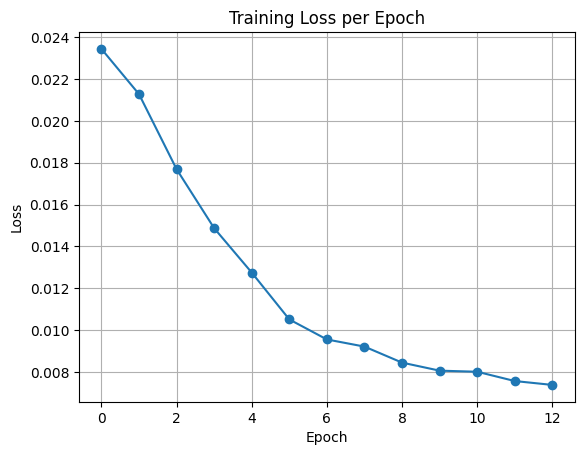

In [9]:
df = pd.read_csv('yolov5/runs/train/train_without_test/results.csv', sep=',')  # Use '\t' as the delimiter
#cls_loss measures the accuracy of class predictions.
df.columns = df.columns.str.strip()
# Create the loss graph
epochs= df['epoch'] 
losses= df['train/obj_loss']
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()

# Testing on images

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/ankitanegi/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-8-14 Python-3.8.17 torch-2.0.1 CPU

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


.DS_Store :
 total_image:  0 D_label :  0 A_label :  0 Y_label :  0


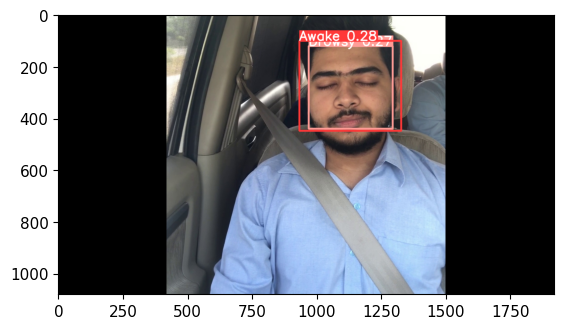

Drowsy :
 total_image:  617 D_label :  351 A_label :  13 Y_label :  1
Yawn :
 total_image:  169 D_label :  0 A_label :  0 Y_label :  1
Awake :
 total_image:  397 D_label :  0 A_label :  50 Y_label :  3


,Label,Total_Image,D_Label,A_Label,Y_Label
0,.DS_Store,0,0,0,0
1,Drowsy,617,351,13,1
2,Yawn,169,0,0,1
3,Awake,397,0,50,3


In [10]:
#testing firs ton an image on best.pt weight
model_1 = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/train_without_test/weights/best.pt', force_reload=True)

data_dir = 'datapreprocessing/Dataset/'
data = { 'Label': [], 'Total_Image': [],'D_Label': [], 'A_Label': [], 'Y_Label': []}

count=0 #just to show only one pciture detected with 2 frame

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    total_image, D_label, A_label, Y_label =0, 0, 0 , 0
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.lower().endswith('.jpg'):
                total_image+=1
                img = os.path.join(data_dir,label, image_file)
                results = model_1(img)
                
                results=str(results)
                
                labels_start = results.find("1 ")  # Find the start of label information
                labels_end = results.find("Speed:")  # Find the end of label information
                labels_info = results[labels_start:labels_end].strip()
                labels_info=sorted(labels_info.split(','))
                labels_info = [label.lower().strip() for label in labels_info]
                D_label += labels_info.count('1 drowsy')
                A_label += labels_info.count('1 awake')
                Y_label += labels_info.count('1 yawn')
                
                #print if 2 frame detected
                if len(labels_info)>1 and count==0:
                    count==1
                    results = model_1(img)
                    %matplotlib inline 
                    plt.imshow(np.squeeze(results.render()))
                    plt.show()

    print(label,":\n", "total_image: ", total_image,"D_label : ", D_label, "A_label : ",A_label,"Y_label : ", Y_label)
    data['Label'].append(label)
    data['Total_Image'].append(total_image)
    data['D_Label'].append(D_label)
    data['A_Label'].append(A_label)
    data['Y_Label'].append(Y_label)
    
label_best_weigth_mapping_df = pd.DataFrame(data)
label_best_weigth_mapping_df   

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/ankitanegi/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-8-14 Python-3.8.17 torch-2.0.1 CPU

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


.DS_Store :
 total_image:  0 D_label :  0 A_label :  0 Y_label :  0


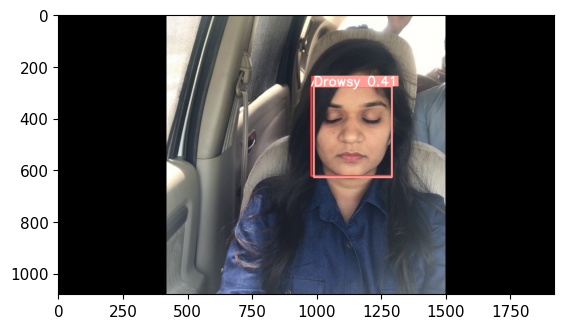

In [ ]:
#testing firs ton an image on last.pt weight
model_2 = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/train_without_test/weights/last.pt', force_reload=True)

data_dir = 'datapreprocessing/Dataset/'
data = { 'Label': [], 'Total_Image': [],'D_Label': [], 'A_Label': [], 'Y_Label': []}

count=0 #just to show only one pciture detected with 2 frame

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    total_image, D_label, A_label, Y_label =0, 0, 0 , 0
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.lower().endswith('.jpg'):
                total_image+=1
                img = os.path.join(data_dir,label, image_file)
                results = model_2(img)
                
                results=str(results)
                
                labels_start = results.find("1 ")  # Find the start of label information
                labels_end = results.find("Speed:")  # Find the end of label information
                labels_info = results[labels_start:labels_end].strip()
                labels_info=sorted(labels_info.split(','))
                labels_info = [label.lower().strip() for label in labels_info]
                D_label += labels_info.count('1 drowsy')
                A_label += labels_info.count('1 awake')
                Y_label += labels_info.count('1 yawn')
                
                #print if 2 frame detected
                if len(labels_info)>1 and count==0:
                    count=1
                    results = model_2(img)
                    %matplotlib inline 
                    plt.imshow(np.squeeze(results.render()))
                    plt.show()

    print(label,":\n", "total_image: ", total_image,"D_label : ", D_label, "A_label : ",A_label,"Y_label : ", Y_label)
    data['Label'].append(label)
    data['Total_Image'].append(total_image)
    data['D_Label'].append(D_label)
    data['A_Label'].append(A_label)
    data['Y_Label'].append(Y_label)
label_last_weigth_mapping_df = pd.DataFrame(data)
label_last_weigth_mapping_df  

# Live testing - change the weight location

In [ ]:
from scipy.spatial import distance as dist
# import imutils
# from imutils.video import VideoStream
# from imutils import face_utils
# import argparse
from threading import Thread
import numpy as np
import time
import dlib
import cv2
import os
import random
import shutil
from PIL import Image
import torch
from matplotlib import pyplot as plt

model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/train_without_test/weights/last.pt', force_reload=True)


In [ ]:
cap = cv2.VideoCapture(0)  #frame rate (fps) depend on the specifications of the camera  generally 30/s
fps = cap.get(cv2.CAP_PROP_FPS)   # Get the actual frame rate of the camera
print(f"Camera Frame rate (fps): {fps}")
while cap.isOpened():
    ret, frame = cap.read()
    
    # Make detections 
    results = model(frame)
    results.print()
    
    cv2.imshow('YOLO', np.squeeze(results.render()))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# testing with print message

In [ ]:
# Initialize variables for drowsiness detection
closed_eyes_frames = 0
yawning_frames = 0
closed_eyes_threshold = 10  #ie 20s eye closed Number of consecutive frames for closed eyes to trigger alarm
yawning_threshold = 5  # Number of consecutive frames for yawning to trigger alarm


while cap.isOpened():
    ret, frame = cap.read()     #cap.read() captures the next frame from the video capture.
                                #ret is a boolean value that indicates whether a frame was successfully read, 
                                #frame is the captured frame from the video.
    if not ret:
        break
    
    # Perform inference using the YOLO model
    detections = model(frame)
    detections.print()
    result=str(detections).split('\n')
    cv2.imshow('YOLO', np.squeeze(detections.render()))    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    print( "result", result)
    # Extract and process detection information
    label=result[0].split()[-1]
    
    bbox = result[1].split('(')[-1]
    print("B", len(result), label, bbox , result)
    
    
    if label == "Drowsy" or "detections)":
            closed_eyes_frames += 1
            if closed_eyes_frames >= closed_eyes_threshold:
                print("Closed eyes detected for 10 seconds! Triggering alarm...")
                # Implement alarm logic here
    else:
        closed_eyes_frames = 0

    if label == "Yawn":
        yawning_frames += 1
        if yawning_frames >= yawning_threshold:
            print("Yawning detected! Triggering alarm...")
            # Implement alarm logic here
    else:
        yawning_frames = 0

# Display the processed frame
# cv2.imshow("Drowsiness Detection", frame)

# if cv2.waitKey(1) & 0xFF == ord('q'):
#     break
        
        
cap.release()
cv2.destroyAllWindows()

# Testing with alarm

In [ ]:
# to give alarm message

def alarm(msg):
    global alarm_status
    global alarm_status2
    global saying

    while alarm_status:
        print('call')
        s = 'espeak "'+msg+'"'
        os.system(s)

    if alarm_status2:
        print('call')
        saying = True
        s = 'espeak "' + msg + '"'
        os.system(s)
        saying = False



alarm_status = False
alarm_status2 = False
saying = False

model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp2/weights/last.pt', force_reload=True)

# Initialize variables for drowsiness detection
closed_eyes_frames = 0
yawning_frames = 0
closed_eyes_threshold = 10  #ie 20s eye closed Number of consecutive frames for closed eyes to trigger alarm
yawning_threshold = 5  # Number of consecutive frames for yawning to trigger alarm

# Open the video capture
cap = cv2.VideoCapture(0)  #frame rate (fps) depend on the specifications of the camera  generally 30 frame/s
#cap = cv2.VideoCapture("path_to_input_video")  #to test on recorded video

fps = cap.get(cv2.CAP_PROP_FPS)   # Get the actual frame rate of the camera
print(f"Camera Frame rate (fps): {fps}")

while cap.isOpened():
    ret, frame = cap.read()     #cap.read() captures the next frame from the video capture.
                                #ret is a boolean value that indicates whether a frame was successfully read, frame is the captured frame from the video.
    if not ret:
        break
    
    # Perform inference using the YOLO model
    detections = model.detect(frame)
    
    # Process detection results
    for detection in detections:
        label, confidence, bbox = detection
        x, y, w, h = bbox
        
        if label == "Drowsy":
            closed_eyes_frames += 1
            if closed_eyes_frames >= closed_eyes_threshold:
                print("Closed eyes detected for 10 seconds! Triggering alarm...")
                if alarm_status == False:
                    alarm_status = True
                    t = Thread(target=alarm, args=('wake up sir',))
                    t.deamon = True
                    t.start()

                cv2.putText(frame, "DROWSINESS ALERT!", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

                # Implement alarm logic here
        else:
            closed_eyes_frames = 0
            COUNTER = 0
            alarm_status = False
        
        if label == "Yawn":
            yawning_frames += 1
            if yawning_frames >= yawning_threshold:
                print("Yawning detected! Triggering alarm...")
                if alarm_status2 == False and saying == False:
                    alarm_status2 = True
                    t = Thread(target=alarm, args=('take some fresh air sir',))
                    t.deamon = True
                    t.start()
                # Implement alarm logic here
        else:
            yawning_frames = 0
            alarm_status2 = False
    
    # Display the processed frame
    cv2.imshow("Drowsiness Detection", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 4: Alarm System
# Implement alarm logic using libraries like playsound, etc.
